# MARKOV TAXA LEVEL ANALYSES

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.colors as pltcolors
from matplotlib.patches import Ellipse
from matplotlib import animation
import scipy as sp
import scipy.stats as stats
from scipy.cluster import hierarchy
import pykov
import rpy2
import string
import random
import time
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from IPython.display import HTML
from collections import defaultdict
from copy import deepcopy
%load_ext rpy2.ipython

In [2]:
def prettify_ax(ax):
    """
    Nifty function we can use to make our axes more pleasant to look at
    """
    for spine in ax.spines.itervalues():
        spine.set_visible(False)
    ax.set_frameon=True
    ax.patch.set_facecolor('#eeeeef')
    ax.grid('on', color='w', linestyle='-', linewidth=1)
    ax.tick_params(direction='out')
    ax.set_axisbelow(True)
    
def simple_ax(figsize=(6,4), **kwargs):
    """
    Shortcut to make and 'prettify' a simple figure with 1 axis
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, **kwargs)
    prettify_ax(ax)
    return fig, ax

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

COLORS = ['#FF9600', '#00A200', '#3359D4', '#A71865']
COLORS2 = ['#696969','#A00000']

In [3]:
# read in data
rawotu = pd.read_csv('data/abundance_table.csv', index_col=0)
rawotu.index = ['.'.join(a.split('.')[:3]) for a in rawotu.index]
weak_trans_idx = pd.read_csv('data/WeakTransitioningIdx.csv', index_col=0).values[:,0] #file written below
fracotu = rawotu.drop(weak_trans_idx)

In [4]:
# make hash table from id number to sample visits
ids = defaultdict(list)
for i in fracotu.index.values:
    a,b,c = i.split('.')
    ids[a+'.'+b].append(int(c))
for k in ids.keys():
    ids[k] = sorted(ids[k])
    nonadjacents, adjflag = [], False #remove non-adjacent timepoints
    for i in range(0,len(ids[k])-1):
        if ids[k][i]+1==ids[k][i+1]:
            adjflag = True
        else:
            if not adjflag:
                nonadjacents.append(i)
            if i==len(ids[k])-2:
                nonadjacents.append(i+1)
            adjflag = False
    for idx in sorted(nonadjacents, reverse=True):
        ids[k].pop(idx)
    if len(ids[k]) in [0,1]: #if no longitudinals, drop sample
        ids.pop(k)
idslist = sorted([k+'.'+str(e) for k in ids for e in ids[k]])
print "There are", len(ids), "patients with", len(idslist), "total samples; with timepoints listed below:"
dict(ids)

There are 81 patients with 286 total samples; with timepoints listed below:


{'0001.003': [1, 2, 3, 4, 5, 6],
 '0008.007': [3, 4, 5, 6],
 '0018.017': [3, 4, 5],
 '0029.043': [2, 3, 4],
 '0032.033': [1, 2, 4, 5, 6],
 '0036.028': [3, 4, 5, 6],
 '0041.030': [3, 4],
 '0044.034': [1, 2, 3, 4],
 '0047.038': [3, 4, 5],
 '0051.064': [5, 6],
 '0055.051': [1, 2, 3, 5, 6, 7],
 '0058.068': [1, 2, 3, 4],
 '0061.057': [2, 3, 4],
 '0067.062': [1, 2, 3, 4, 5, 6],
 '0068.050': [1, 2, 3, 4, 5, 6],
 '0079.069': [1, 2, 3, 4, 5, 6, 7],
 '0085.075': [1, 2, 3, 4, 5, 6],
 '0090.080': [1, 2, 3, 4, 5, 6, 7],
 '0094.086': [1, 2, 3, 5, 6, 7, 8],
 '0098.098': [1, 2],
 '0100.083': [1, 2, 3, 4],
 '0101.088': [1, 2, 3, 4, 5, 6],
 '0106.082': [2, 3],
 '0121.101': [1, 2, 3],
 '0123.103': [4, 5],
 '0135.111': [2, 3, 5, 6],
 '0136.112': [1, 2, 3, 4, 5],
 '0138.113': [1, 2, 4, 5],
 '0139.114': [1, 2, 3],
 '0154.119': [2, 3, 4, 5],
 '0158.129': [1, 2, 3, 4],
 '0180.142': [1, 2, 3, 6, 7, 8],
 '0203.151': [1, 2, 3],
 '0218.162': [1, 2, 3, 4, 5],
 '0229.171': [1, 2],
 '0262.198': [1, 2],
 '0275.201': 

In [5]:
# filter fracotu by longitudinal samples
fracotu = fracotu.loc[idslist,:]

# merge prevotella species
genera_tomerge = ['Lachnospiraceae','Prevotellaceae Prevotella','Actinomycetaceae Mobiluncus','Corynebacteriaceae Corynebacterium','Coriobacteriaceae Atopobium'] 
for e,gns in enumerate(genera_tomerge):
    num_prefices = 1 if e==0 else 2
    sp_tomerge = [a for a in fracotu.columns if ' '.join(a.split(' ')[:num_prefices])==gns]
    fracotu[gns] = fracotu[sp_tomerge].sum(1)
    fracotu = fracotu.drop(sp_tomerge, 1)
fracotu = fracotu.loc[:,fracotu.sum(0).sort_values(ascending=False).index]
print fracotu.shape
fracotu.head()

(286, 163)


,Lactobacillaceae Lactobacillus iners,Bifidobacteriaceae Gardnerella vaginalis,Lactobacillaceae Lactobacillus no_iners,Prevotellaceae Prevotella,Leptotrichiaceae Sneathia sanguinegens,Actinomycetaceae Mobiluncus,Coriobacteriaceae Atopobium,Aerococcaceae Aerococcus christensenii,Peptostreptococcaceae Peptostreptococcus anaerobius,Bacillales_Incertae_Sedis_XI Gemella asaccharolytica,...,Veillonellaceae Dialister invisus,Ruminococcaceae Butyricicoccus pullicaecorum,Streptococcaceae Streptococcus mutans,Coriobacteriaceae Eggerthella sinensis,Sphingomonadaceae Sphingomonas koreensis,Peptostreptococcaceae Intestinibacter bartlettii,Clostridiaceae_1 Clostridium_sensu_stricto paraputrificum,Acidaminococcaceae Acidaminococcus fermentans,Veillonellaceae Megasphaera micronuciformis,Bacteroidaceae Bacteroides uniformis
0001.003.1,0.000537,0.713093,0.000000,0.006348,0.037645,0.0,0.211000,0.026989,0.0,0.003436,...,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
0001.003.2,0.999728,0.000272,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
0001.003.3,0.999313,0.000501,0.000111,0.000000,0.000000,0.0,0.000074,0.000000,0.0,0.000000,...,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
0001.003.4,0.999695,0.000305,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
0001.003.5,0.760264,0.000000,0.239736,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [6]:
# calculate dominance for each sample
Lcrisp, Liners, Gvag = 'Lactobacillaceae Lactobacillus no_iners', 'Lactobacillaceae Lactobacillus iners', 'Bifidobacteriaceae Gardnerella vaginalis'
domtaxa_abund = {Lcrisp:[], Liners:[], Gvag:[], 'other':[]}
for colnum in range(rawotu.T.shape[1]):
    col_curr = rawotu.T.iloc[:, colnum].sort_values(ascending=False)
    dom_curr, dom_abund = col_curr.index.values[0], col_curr[0]
    if dom_curr in [Lcrisp, Liners, Gvag]:
        domtaxa_abund[dom_curr].append(col_curr[0]) 
    else:
        domtaxa_abund['other'].append(col_curr[0])

cutoffs = {Lcrisp:0, Liners:0, Gvag:0, 'other':0} #determine cutoffs
for species in [Lcrisp, Liners, Gvag, 'other']:
    abundances = np.array(domtaxa_abund[species])
    cutoffs[species] = np.percentile(abundances, 5)
    
weak_trans_idx = []
for colnum in range(rawotu.T.shape[1]):
    col_curr = rawotu.T.iloc[:, colnum].sort_values(ascending=False)
    dom_curr, dom_abund = col_curr.index.values[0], col_curr[0]
    if dom_curr in [Lcrisp, Liners, Gvag] and dom_abund<cutoffs[dom_curr]:
        weak_trans_idx.append(col_curr.name)
    elif dom_abund<cutoffs['other']:
        weak_trans_idx.append(col_curr.name)
#pd.DataFrame(weak_trans_idx).to_csv('data/WeakTransitioningIdx.csv') #file called above

### Assign CTs

In [7]:
# assign a CT to each sample
cts = []
Lcrisp, Liners, Gvag = 'Lactobacillaceae Lactobacillus no_iners', 'Lactobacillaceae Lactobacillus iners', 'Bifidobacteriaceae Gardnerella vaginalis'
domtaxa_abund = {Lcrisp:[], Liners:[], Gvag:[], 'other':[]}
for colnum in range(fracotu.T.shape[1]):
    col_curr = fracotu.T.iloc[:, colnum].sort_values(ascending=False)
    dom_curr, dom_bool = col_curr.index.values[0], col_curr[0]>0.45
    if dom_curr in [Lcrisp, Liners, Gvag]:
        domtaxa_abund[dom_curr].append(col_curr[0]) 
    else:
        domtaxa_abund['other'].append(col_curr[0]) 
    if dom_curr == Lcrisp and dom_bool:
        cts.append(1)
    elif dom_curr == Liners and dom_bool:
        cts.append(2)
    elif dom_curr == Gvag and dom_bool:
        cts.append(3)
    else:
        cts.append(4)
ct_df = pd.DataFrame(data={'CT':cts},index=fracotu.T.columns.values)
ct_df.head()

,CT
0001.003.1,3
0001.003.2,2
0001.003.3,2
0001.003.4,2
0001.003.5,2


In [8]:
# create dictionaries with patient id keys and timepoint/ct values
time_ct_dict = {} #values are tuples of timepoint and ct
ct_dict = {} #values are cts
for k in ids.keys():
    curr_cts = []
    curr_timects = []
    for t in ids[k]:
        idcurr = k+'.'+str(t)
        tup = (t, ct_df.loc[idcurr, 'CT'])
        curr_timects.append(tup)
        curr_cts.append(tup[1])
    time_ct_dict[k] = curr_timects
    ct_dict[k] = curr_cts
ct_dict

{'0001.003': [3, 2, 2, 2, 2, 2],
 '0008.007': [2, 1, 1, 1],
 '0018.017': [3, 3, 4],
 '0029.043': [4, 4, 4],
 '0032.033': [2, 4, 3, 2, 4],
 '0036.028': [3, 3, 4, 4],
 '0041.030': [2, 3],
 '0044.034': [2, 3, 3, 3],
 '0047.038': [2, 2, 2],
 '0051.064': [4, 4],
 '0055.051': [1, 2, 1, 3, 3, 4],
 '0058.068': [2, 2, 4, 3],
 '0061.057': [4, 4, 3],
 '0067.062': [3, 2, 3, 3, 1, 1],
 '0068.050': [2, 1, 2, 2, 2, 2],
 '0079.069': [3, 4, 3, 3, 2, 4, 4],
 '0085.075': [2, 4, 2, 2, 2, 4],
 '0090.080': [2, 2, 2, 3, 3, 3, 4],
 '0094.086': [2, 1, 2, 2, 2, 2, 2],
 '0098.098': [2, 2],
 '0100.083': [4, 4, 4, 4],
 '0101.088': [3, 3, 4, 3, 2, 2],
 '0106.082': [2, 4],
 '0121.101': [4, 3, 4],
 '0123.103': [4, 4],
 '0135.111': [1, 1, 2, 4],
 '0136.112': [3, 4, 2, 4, 3],
 '0138.113': [4, 2, 1, 2],
 '0139.114': [2, 2, 2],
 '0154.119': [3, 3, 4, 2],
 '0158.129': [1, 1, 1, 1],
 '0180.142': [4, 2, 1, 2, 3, 2],
 '0203.151': [3, 3, 4],
 '0218.162': [2, 2, 2, 2, 3],
 '0229.171': [2, 1],
 '0262.198': [2, 2],
 '0275.201': 

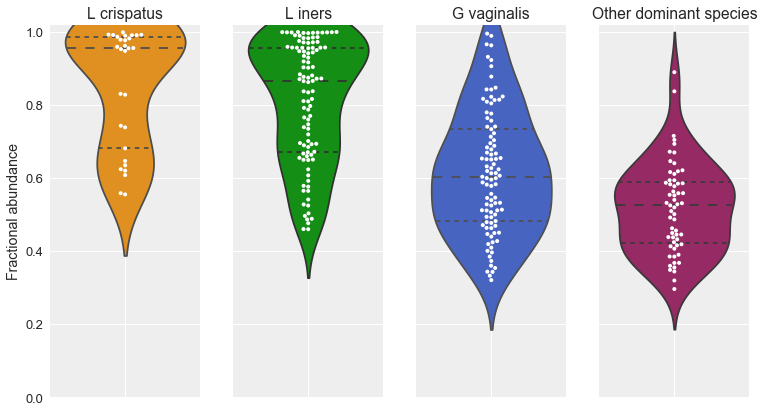

In [10]:
f, axarr = plt.subplots(1,4, figsize=(11,6))
sns.set(font_scale=1.3)
titles = ['L crispatus', 'L iners', 'G vaginalis', 'Other dominant species']
for e,ct in enumerate([Lcrisp, Liners, Gvag, 'other']):
    ax = axarr[e]
    sns.violinplot(domtaxa_abund[ct], orient='v', color=COLORS[e], inner='quartiles', ax=ax)
    sns.swarmplot(domtaxa_abund[ct], orient='v', color='white', size=4, ax=ax)
    ax.set_title(titles[e])
    ax.set_ylim([0,1.02])
    if e==0:
        ax.set_ylabel('Fractional abundance')
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    prettify_ax(ax)
plt.tight_layout()
plt.savefig('figures/dominant_species_abundances.pdf', bbox_inches='tight')
plt.show()

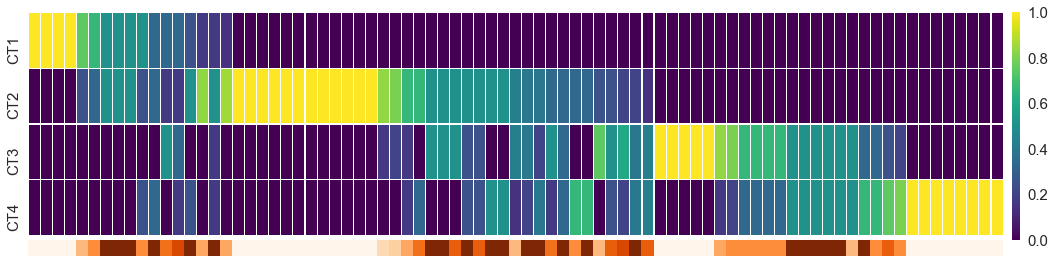

In [12]:
# count number of visits per CT by patient, and number of transitions by patient
visits = pd.DataFrame(0, index=['CT1','CT2','CT3','CT4'], columns=ct_dict.keys())
sample_transitions = pd.DataFrame(0, index=['Transitions', 'Holds'], columns=ct_dict.keys())
for k in ct_dict.keys():
    transitioning = False
    for i in range(len(ct_dict[k])-1):
        starttime, endtime = ids[k][i], ids[k][i+1]
        if endtime==starttime+1:
            visits.loc['CT'+str(ct_dict[k][i+1]),k] += 1
            if not transitioning:
                visits.loc['CT'+str(ct_dict[k][i]),k] += 1
                transitioning = True
            if ct_dict[k][i]!=ct_dict[k][i+1]:
                sample_transitions.loc['Transitions',k] += 1
            else:
                sample_transitions.loc['Holds',k] += 1
        else:
            transitioning = False
visits = visits.div(visits.sum(0),1)
visits = visits.sort_values(axis=1, by=['CT1','CT2','CT3','CT4'], ascending=False)
fracs = sample_transitions.div(sample_transitions.sum(0),1)
fracs = fracs.loc['Transitions',visits.columns]
fracs.fillna(0)

# plot
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(10, 10, width_ratios=range(8)+[0.25,0.25], height_ratios=range(8)+[0.5,2])
gs.update(wspace=0, hspace=0)
ax1 = fig.add_subplot(gs[:-2, :-2])
ax3 = fig.add_subplot(gs[:-1, -1], xmargin=1)
sns.heatmap(visits, linewidths=0.05, cmap='viridis', xticklabels=False, ax=ax1, cbar_ax=ax3)           
ax2 = fig.add_subplot(gs[-1,:-2])
sns.heatmap([fracs.values], cmap='Oranges', cbar=False)
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.savefig('figures/visits.pdf', bbox_inches='tight')
plt.show()

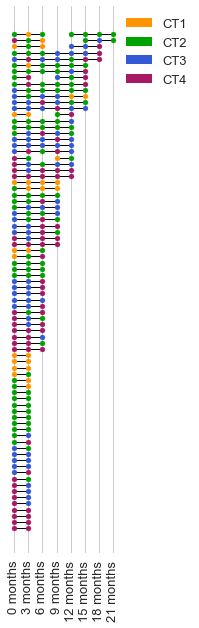

In [9]:
#plot sample collection times
ordered_k = sorted(ids.keys(), key=lambda k:(max(np.array(ids[k])-min(ids[k])+1),-ct_dict[k][0],-ct_dict[k][1]))
sns.set(font_scale=1.3)
sns.set_style("whitegrid")
fig = plt.figure(figsize=(3,9))
ax = fig.add_subplot(111)
ax.set_yticks([])
#ax.grid('off')
sns.despine(left=True, bottom=True, right=True)
for y,k in enumerate(ordered_k):
    scaled = list(np.array(ids[k])-min(ids[k])+1)
    #ax.plot([min(scaled),max(scaled)], [y,y], linewidth=1, c='k', zorder=1)
    for e,t in enumerate(scaled):
        ax.scatter(t, y, c=COLORS[ct_dict[k][e]-1], s=25, zorder=2)
        if e!=0 and t==scaled[e-1]+1:
            ax.plot([t-1,t], [y,y], linewidth=1, c='k', zorder=1)
ax.set_xticks(range(1,9))
ax.set_xticklabels([str(e)+' months' for e in np.arange(0,22,3)],rotation=90)
recs = []
for i in range(4):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=COLORS[i]))
ax.legend(recs,['CT1', 'CT2', 'CT3', 'CT4'], prop={'size':13}, bbox_to_anchor=(.95, 1))
plt.tight_layout()
plt.savefig('figures/samplecollection.pdf', bbox_inches='tight')
plt.show()

### Create CT transition counts matrix

In [10]:
# create dictionary of ids that transition to a given ct based on starting ct
transitions = np.zeros((4,4)) #also keep track of number of transitions
cttrans_dict = defaultdict(list)
for k in ct_dict.keys():
    for i in range(len(ct_dict[k])-1):
        starttime, endtime = ids[k][i], ids[k][i+1]
        if endtime==starttime+1:
            startct, endct = ct_dict[k][i], ct_dict[k][i+1]
            transitions[startct-1][endct-1] += 1
            curr_trans = 'CT'+str(startct)+'_WR' if startct==endct else 'CT'+str(startct)+'_WNR'
            startid = k+'.'+str(starttime)
            cttrans_dict[curr_trans].append(startid)

In [11]:
# generate a ct transitions matrix and save as csv
transitions_df = pd.DataFrame(data=transitions, \
                              index=['From CT1', 'From CT2', 'From CT3', 'From CT4'], \
                              columns=['To CT1', 'To CT2', 'To CT3', 'To CT4'])
transitions_df.to_csv('data/ct_transitions.csv')
print "There were", int(transitions.sum()), "total transitions observed in the dataset."
transitions_df

There were 199 total transitions observed in the dataset.


,To CT1,To CT2,To CT3,To CT4
From CT1,11.0,7.0,0.0,0.0
From CT2,7.0,43.0,10.0,12.0
From CT3,1.0,12.0,29.0,19.0
From CT4,0.0,9.0,17.0,22.0


### Calculate $\beta$-diversity

In [12]:
# rarefy dada2 abundances to 5000 counts
rarefy5000 = np.ceil(fracotu*5000).astype('int').T
rarefy5000.index.name = "taxa"
rarefy5000.to_csv('data/qiime/1rarefaction5000/rarefy5000.txt', sep='\t')

*** Terminal commands to convert filtered counts to biom, run bray-curtis beta diversity, and pcoa project ***
```bash
biom convert -i 1rarefaction5000/rarefy5000.txt -o 1rarefaction5000/rarefy5000.biom --table-type="OTU table" --to-hdf5
beta_diversity.py -i 1rarefaction5000/rarefy5000.biom -o 2betadiversity/ -m bray_curtis
principal_coordinates.py -i 2betadiversity/bray_curtis_rarefy5000.txt -o 3pcoa/pcoa_coords.txt
```

In [13]:
# calculate braycurtis beta diversity and confirm qiime output from 3betadiversity/
bc_dm = beta_diversity("braycurtis", np.array(rarefy5000.T), rarefy5000.T.index.values)
print(bc_dm)

286x286 distance matrix
IDs:
'0001.003.1', '0001.003.2', '0001.003.3', '0001.003.4', '0001.003.5', ...
Data:
[[0.00000000e+00 9.99000500e-01 9.98600839e-01 ... 3.41127098e-01
  9.92412141e-01 7.36237386e-01]
 [9.99000500e-01 0.00000000e+00 4.99850045e-04 ... 9.98600700e-01
  2.92619595e-02 3.07215671e-01]
 [9.98600839e-01 4.99850045e-04 0.00000000e+00 ... 9.98400959e-01
  2.87597364e-02 3.06685320e-01]
 ...
 [3.41127098e-01 9.98600700e-01 9.98400959e-01 ... 0.00000000e+00
  9.92012780e-01 7.36637027e-01]
 [9.92412141e-01 2.92619595e-02 2.87597364e-02 ... 9.92012780e-01
  0.00000000e+00 2.89008685e-01]
 [7.36237386e-01 3.07215671e-01 3.06685320e-01 ... 7.36637027e-01
  2.89008685e-01 0.00000000e+00]]


### Unsupervised hierarchical clustering

In [15]:
# generate linkage matrix with ward linkage, euclidean distance metric
Z = hierarchy.linkage(bc_dm.condensed_form(), 'ward')

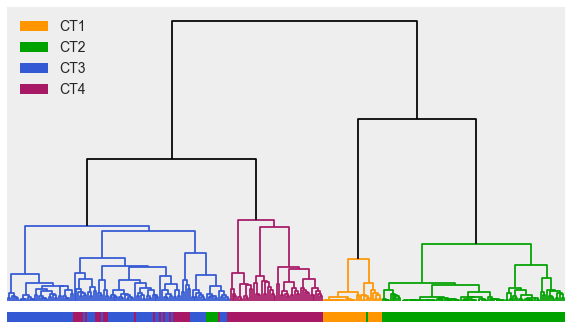

In [17]:
# plot dendrogram from linkage matrix
fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(10, 10)
gs.update(wspace=0, hspace=0)

ct_cmap = pltcolors.ListedColormap(COLORS)
hierarchy.set_link_color_palette([COLORS[i] for i in [2,3,0,1]])
ax1 = fig.add_subplot(gs[:-1, :])
d = hierarchy.dendrogram(Z, no_labels=True, color_threshold=0.4*max(Z[:,2]), \
                         above_threshold_color='k', ax=ax1)
ax1.set_yticks([])
recs = []
for i in range(4):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=COLORS[i]))
ax1.legend(recs,['CT1', 'CT2', 'CT3', 'CT4'], loc=2, prop={'size':14})
ax1.set_xticks([])
ax1.set_yticks([])
prettify_ax(ax1)

# plot ct labels
ct_labels = []
for idx in d['leaves']:
    ctcurr = ct_df.CT[bc_dm.ids[idx]]
    ct_labels.append(ctcurr)
ax2 = fig.add_subplot(gs[-1,:])
ax2.matshow([ct_labels]*5, cmap=ct_cmap, interpolation='none')
ax2.set_xticks([])
ax2.set_yticks([])

plt.savefig('figures/hier_cluster.pdf', bbox_inches='tight')
plt.show()

### PCoA plotting

** NOTE : qiime output pcoa_coords.txt file must be manually fixed in excel. Make percent variance the header, delete superfluous rows at the top of the file, and delete superfluous rows at the bottom of the file. **

In [14]:
# read in pcoa coordinates from qiime output
pcoa_df = pd.read_csv('data/qiime/3pcoa/pcoa_coords.txt', sep='\t', index_col=0)
pcoa_df.index.name = 'Sample'
pcoa_df.head()

,0.413477012,0.176459157,0.134045755,0.05146706,0.038832945,0.028710698,0.021162792,0.015030515,0.011851543,0.009348131,...,0.165,0.166,0.167,0.168,0.169,0.170,0.171,0.172,0.173,0.174
Sample,,,,,,,,,,,,,,,,,,,,,
0001.003.1,-0.424954,0.118914,-0.279175,0.047990,-0.007941,0.007260,-0.214713,0.000113,-0.027606,0.029143,...,0,0,0,0,0,0,0,0,0,0
0001.003.2,0.506031,0.189095,0.074260,0.040460,-0.047550,0.078208,-0.044807,0.006023,-0.006330,0.025162,...,0,0,0,0,0,0,0,0,0,0
0001.003.3,0.505506,0.188876,0.074249,0.040541,-0.047426,0.077934,-0.044864,0.006119,-0.006368,0.024992,...,0,0,0,0,0,0,0,0,0,0
0001.003.4,0.506031,0.189095,0.074260,0.040460,-0.047550,0.078208,-0.044807,0.006023,-0.006330,0.025162,...,0,0,0,0,0,0,0,0,0,0
0001.003.5,0.523486,-0.033544,-0.045042,-0.011698,0.005734,-0.004369,0.026429,-0.004947,0.013413,0.014083,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# form ellipse centroids with 2 stdevs width
def generate_ellipses():
    global pcoa_df, ct_df
    col1, col2 = pcoa_df.columns.values[0], pcoa_df.columns.values[1]
    ellipses = []
    for ct in range(1,5):
        ctpts = pcoa_df.loc[ct_df[ct_df.CT==ct].index,:]
        x, y = ctpts[col1], ctpts[col2]
        cov = np.cov(x, y)
        lambda_, v = np.linalg.eig(cov)
        lambda_ = np.sqrt(lambda_)
        ell = Ellipse(xy=(np.mean(x), np.mean(y)), width=lambda_[0]*2*2, height=lambda_[1]*2*2,
                      angle=np.rad2deg(np.arccos(v[0, 0])), alpha=0.3)
        ell.set_facecolor(COLORS[ct-1])
        ellipses.append(ell)
    return ellipses

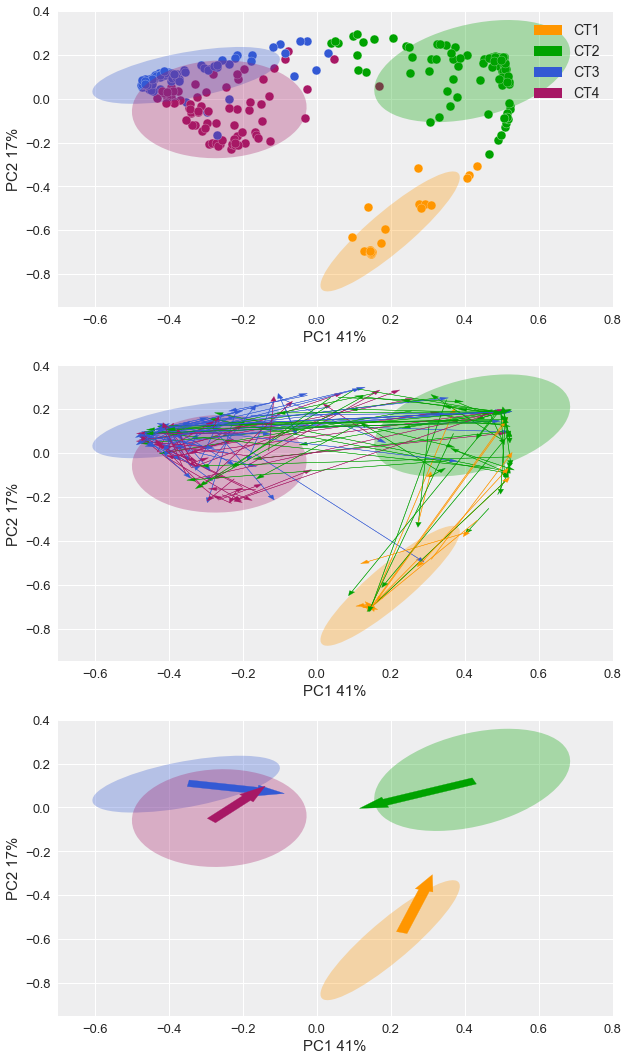

In [21]:
# plot 2d pcoa projection with arrow movement
f, axarr = plt.subplots(3, 1, figsize=(9,15))
col1, col2 = pcoa_df.columns.values[0], pcoa_df.columns.values[1]

for ell in generate_ellipses():
    axarr[0].add_artist(ell)
for sampleid in pcoa_df.index.values: #scatter
    ct = ct_df.loc[sampleid, 'CT']
    axarr[0].scatter(pcoa_df.loc[sampleid, col1], \
                     pcoa_df.loc[sampleid, col2], \
                     c=COLORS[ct-1], \
                     edgecolors='w', \
                     s=80)
recs = []
for i in range(4):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=COLORS[i]))
axarr[0].legend(recs,['CT1', 'CT2', 'CT3', 'CT4'], loc=1,prop={'size':14})

for ell in generate_ellipses():
    axarr[1].add_artist(ell)
deltaxy_dict = {"CT1":[], "CT2":[], "CT3":[], "CT4":[]}
for k in ids.keys(): #arrows
    for t in range(len(ids[k])-1):
        if ids[k][t+1]==1+ids[k][t]:
            currid = k+'.'+str(ids[k][t])
            startct = ct_df.loc[currid, 'CT']
            arrowcolor = COLORS[startct-1]
            nextid = k+'.'+str(ids[k][t+1])
            deltax = pcoa_df.loc[nextid, col1] - pcoa_df.loc[currid, col1]
            deltay = pcoa_df.loc[nextid, col2] - pcoa_df.loc[currid, col2]
            tailx = pcoa_df.loc[currid, col1]
            taily = pcoa_df.loc[currid, col2]
            deltaxy_dict['CT'+str(startct)].append((tailx,taily,deltax,deltay))
            axarr[1].arrow(tailx, taily, deltax, deltay, \
                           fc=arrowcolor, ec=arrowcolor, head_width=0.015)

for ell in generate_ellipses():
    axarr[2].add_artist(ell)
for ct_num in range(4): #make overarching broad arrows as vector sum
    ct_curr = 'CT' + str(ct_num+1)
    arrowcolor = COLORS[ct_num]
    x_curr = np.mean([a[0] for a in deltaxy_dict[ct_curr]])
    y_curr = np.mean([a[1] for a in deltaxy_dict[ct_curr]])
    deltax_curr = np.mean([a[2] for a in deltaxy_dict[ct_curr]])
    deltay_curr = np.mean([a[3] for a in deltaxy_dict[ct_curr]])
    axarr[2].arrow(x_curr, y_curr, deltax_curr, deltay_curr, \
                   fc=arrowcolor, ec=arrowcolor, width = .03, head_width=0.05)

for a in range(3): #format
    prettify_ax(axarr[a])
    xlabel = 'PC1 ' + str(int(float(col1)*100))+'%'
    ylabel = 'PC2 ' + str(int(float(col2)*100))+'%'
    axarr[a].set_xlabel(xlabel, fontsize=15)
    axarr[a].set_ylabel(ylabel, fontsize=15)
    axarr[a].set_xlim([-.7,.8])
    axarr[a].set_ylim([-.95,.4])
        
plt.tight_layout()
plt.savefig('figures/pcoa_2d.pdf', bbox_inches='tight')
plt.show()

In [22]:
# L iners appears to be able to co-dominate with other species, unlike L Crisp
rawotu.loc[ct_df[ct_df.CT==4].index,:].sort_values('Lactobacillaceae Lactobacillus iners',ascending=False).iloc[:3,:4]

,Lactobacillaceae Lactobacillus iners,Lactobacillaceae Lactobacillus no_iners,Bifidobacteriaceae Gardnerella vaginalis,Coriobacteriaceae Atopobium vaginae
0788.597.3,0.427243,0.091855,0.446896,0.001734
0106.082.3,0.346980,0.008631,0.360275,0.012198
0411.296.4,0.336245,0.031968,0.030980,0.509434


In [23]:
rawotu.loc[ct_df[ct_df.CT==4].index,:].sort_values('Lactobacillaceae Lactobacillus no_iners',ascending=False).iloc[:3,:4]

,Lactobacillaceae Lactobacillus iners,Lactobacillaceae Lactobacillus no_iners,Bifidobacteriaceae Gardnerella vaginalis,Coriobacteriaceae Atopobium vaginae
0730.536.3,0.264354,0.154373,0.320707,0.186802
0671.486.3,0.108931,0.119332,0.266260,0.385314
0788.597.3,0.427243,0.091855,0.446896,0.001734


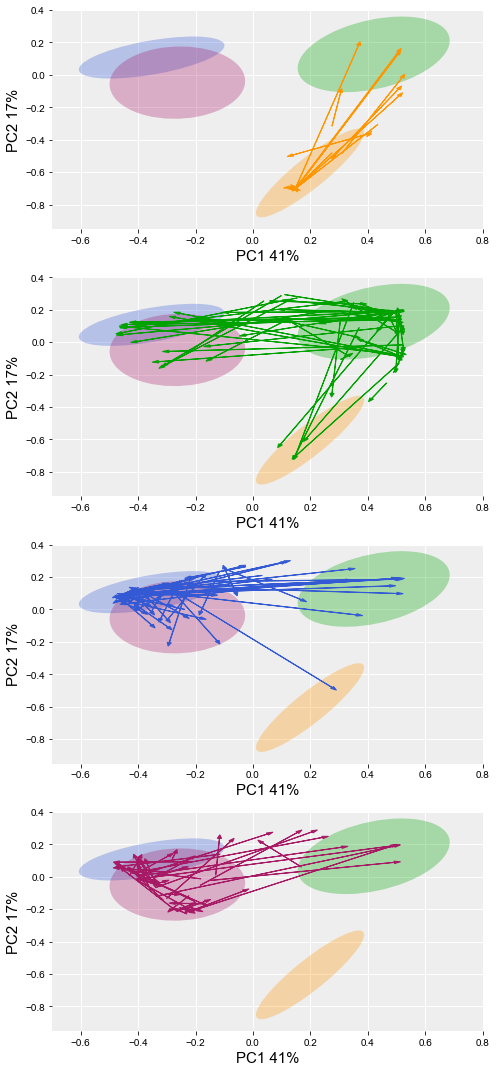

In [21]:
# plot 4 separate pcoa arrow subplots by starting CT
col1, col2 = pcoa_df.columns.values[0], pcoa_df.columns.values[1]
f,axarr = plt.subplots(4,1, figsize=(7,15))
for e,ax in enumerate(f.axes):
    for ell in generate_ellipses():
        ax.add_artist(ell)
    arrowcolor = COLORS[e]
    for k in ids.keys():
        for t in range(len(ids[k])-1):
            if ids[k][t+1]==1+ids[k][t]:
                currid = k+'.'+str(ids[k][t])
                startct = ct_df.loc[currid, 'CT']
                if startct==e+1:
                    nextid = k+'.'+str(ids[k][t+1])
                    deltax = pcoa_df.loc[nextid, col1] - pcoa_df.loc[currid, col1]
                    deltay = pcoa_df.loc[nextid, col2] - pcoa_df.loc[currid, col2]
                    tailx = pcoa_df.loc[currid, col1]
                    taily = pcoa_df.loc[currid, col2]
                    ax.arrow(tailx, taily, deltax, deltay, \
                             fc=arrowcolor, ec=arrowcolor, head_width=0.015)
    prettify_ax(ax)
    xlabel = 'PC1 ' + str(int(float(col1)*100))+'%'
    ylabel = 'PC2 ' + str(int(float(col2)*100))+'%'
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.set_xlim([-.7,.8])
    ax.set_ylim([-.95,.4])
    recs = []
#     if e==3:
#         for i in range(4):
#             recs.append(mpatches.Rectangle((0,0),1,1,fc=COLORS[i]))
#         ax.legend(recs,['CT1', 'CT2', 'CT3', 'CT4'], loc=4,prop={'size':14})
plt.tight_layout()
plt.savefig('figures/separated_pcoaarrows.pdf', bbox_inches='tight')
plt.show()

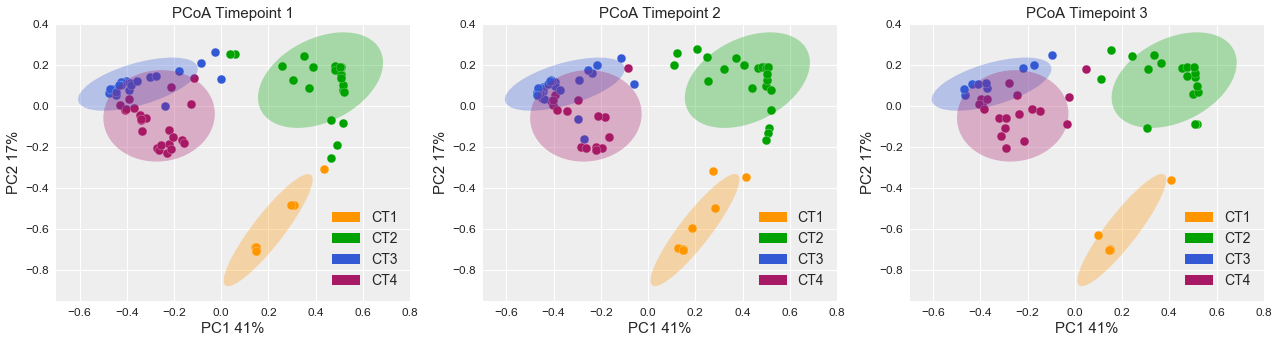

In [120]:
# plot individual timepoints
timepoints = 3
f, axarr = plt.subplots(1, timepoints, figsize=(18,5))
col1, col2 = pcoa_df.columns.values[0], pcoa_df.columns.values[1]

for t in range(timepoints):
    for ell in generate_ellipses():
        axarr[t].add_artist(ell)
    for k in ids.keys():
        try:
            tcurr = ids[k][t]
            validtimepoint = True
        except IndexError:
            validtimepoint = False
        if validtimepoint:
            idcurr = k+'.'+str(tcurr)
            ctcurr = ct_df.loc[idcurr, 'CT']
            axarr[t].scatter(pcoa_df.loc[idcurr, col1], \
                             pcoa_df.loc[idcurr, col2], \
                             c=COLORS[ctcurr-1], \
                             edgecolors='w', \
                             s=80)
    prettify_ax(axarr[t])
    xlabel = 'PC1 ' + str(int(float(col1)*100))+'%'
    ylabel = 'PC2 ' + str(int(float(col2)*100))+'%'
    title = 'PCoA Timepoint ' + str(t+1)
    axarr[t].set_xlabel(xlabel, fontsize=15)
    axarr[t].set_ylabel(ylabel, fontsize=15)
    axarr[t].set_title(title, fontsize=15)
    axarr[t].set_xlim([-.7,.8])
    axarr[t].set_ylim([-.95,.4])
    recs = []
    for i in range(4):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=COLORS[i]))
    axarr[t].legend(recs,['CT1', 'CT2', 'CT3', 'CT4'], loc=4, prop={'size':14})
    
plt.tight_layout()
plt.savefig('figures/pcoa_timepoints.pdf', bbox_inches='tight')
plt.show()

### Alpha Diversity

In [25]:
# create mapping file with current/previous/next ct's as pandas dataframe
map_arr = []
for k in ids.keys():
    for i in range(len(ids[k])):
        currid = k+'.'+str(ids[k][i])
        currct = ct_dict[k][i]
        if i==0:
            prevct = 'NA'
            returnedbool = 'NA'
            returnedstr = 'NA'
        else:
            prevct = ct_dict[k][i-1]
            returnedbool = (prevct == currct)
            returnedstr = "_returned" if returnedbool else "_notreturned"
            returnedstr = str(currct) + returnedstr
        if i==(len(ids[k])-1):
            nextct = 'NA'
            willreturnbool = 'NA'
            willreturnstr = 'NA'
        else:
            nextct = ct_dict[k][i+1]
            willreturnbool = (nextct == currct)
            willreturnstr = "_willreturn" if willreturnbool else "_wontreturn"
            willreturnstr = str(currct) + willreturnstr
        row = [currid, currct, prevct, nextct, \
               returnedbool, willreturnbool, \
               returnedstr, willreturnstr]
        map_arr.append(row)
map_df = pd.DataFrame(data=map_arr, columns=['#SampleID', 'CT_current', 'CT_previous', 'CT_next', \
                                             'Returned_bool', 'Willreturn_bool', 'Returned_CT', 'Willreturn_CT'])
map_df.insert(1, 'BarcodeSequence', np.nan)
map_df.insert(2, 'LinkerPrimerSequence', np.nan)
map_df.insert(map_df.shape[1], 'Description', 'z')
map_df.head()

,#SampleID,BarcodeSequence,LinkerPrimerSequence,CT_current,CT_previous,CT_next,Returned_bool,Willreturn_bool,Returned_CT,Willreturn_CT,Description
0,0262.198.1,NaN,NaN,2,NA,2,NA,True,NA,2_willreturn,z
1,0262.198.2,NaN,NaN,2,2,NA,True,NA,2_returned,NA,z
2,0154.119.2,NaN,NaN,3,NA,3,NA,True,NA,3_willreturn,z
3,0154.119.3,NaN,NaN,3,3,4,True,False,3_returned,3_wontreturn,z
4,0154.119.4,NaN,NaN,4,3,2,False,False,4_notreturned,4_wontreturn,z


In [135]:
# save mapping file to csv
map_df.to_csv('Data/qiime/4map/map.txt', sep='\t', index=False)

*** Validate mapping file (ignoring primer and barcode) with: ***

```bash
validate_mapping_file.py -m 4map/map.txt -o 4map/check/ -p -b
```

***Run qiime's alpha rarefaction pipeline, which rarefies between 10 and 5000 and calculates alpha diversity.***
```bash
alpha_rarefaction.py -i 1rarefaction5000/rarefy5000.biom -o 5alpha_rarefaction/ -m 4map/map.txt -e 5000 -a -O 4 -p 4map/parameters.txt --retain_intermediate_files
```

*** Use monte carlo non-parametric methods to calculate p-value for significance of differences in alpha-diversity between returners and non-returners ***

```bash
compare_alpha_diversity.py -i 5alpha_rarefaction/alpha_div_collated/shannon.txt -m 4map/map.txt -c CT_current,Returned_bool,Willreturn_bool,Returned_CT,Willreturn_CT -o 5alpha_rarefaction/AlphaDivComparisons -p none
```

In [94]:
alphacomp = pd.read_csv('data/qiime/5alpha_rarefaction/AlphaDivComparisons/Willreturn_CT_stats.txt', sep='\t')
alphacomp = alphacomp[alphacomp.Group1.str[0]==alphacomp.Group2.str[0]]
alphacomp

,Group1,Group2,Group1 mean,Group1 std,Group2 mean,Group2 std,t stat,p-value
4,4_willreturn,4_wontreturn,1.979403,0.427902,1.952529,0.381481,0.227402,0.820
29,2_willreturn,2_wontreturn,0.600620,0.551042,0.948186,0.532724,-2.663223,0.014
31,1_willreturn,1_wontreturn,0.629575,0.433487,0.607291,0.547801,0.098751,0.925
35,3_willreturn,3_wontreturn,1.278651,0.490648,1.525361,0.399555,-2.125733,0.030


In [95]:
col5000 = pd.DataFrame(map_df.set_index('#SampleID').Willreturn_CT, columns=['Willreturn_CT'])
col5000 = col5000[col5000.Willreturn_CT!='NA']
adiv = pd.read_csv('data/qiime/5alpha_rarefaction/alpha_div_collated/shannon.txt', sep='\t')
adiv_5000 = adiv[adiv['Unnamed: 0'].str[-10]=='5'].iloc[:,3:].mean(axis=0)
col5000['Alpha_div'] = adiv_5000.loc[col5000.index.values]
col5000.head()

,Willreturn_CT,Alpha_div
#SampleID,,
0262.198.1,2_willreturn,0.027058
0154.119.2,3_willreturn,1.415315
0154.119.3,3_wontreturn,2.014574
0154.119.4,4_wontreturn,1.815045
0047.038.3,2_willreturn,1.794819


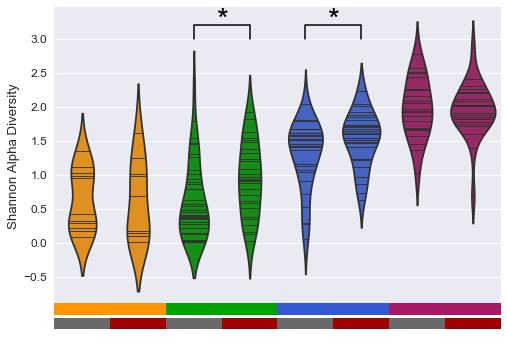

In [119]:
sns.set(font_scale=1.2)
fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(3, 1, height_ratios=[15,1,1])
gs.update(wspace=0, hspace=-.05)
ax = fig.add_subplot(gs[0,:])
sns.violinplot(x="Willreturn_CT", y="Alpha_div", data=col5000, \
            order=sorted(list(set(col5000.Willreturn_CT))), \
            palette=[COLORS[i] for i in np.arange(8)//2], inner='stick', split=True, ax=ax)
ax.plot([2, 2, 3, 3], [3, 3.2, 3.2, 3], lw=1.5, c='k')
ax.text((2+3)*.5, 3.05, "*", ha='center', va='bottom', color='k', fontsize=30)
ax.plot([4, 4, 5, 5], [3, 3.2, 3.2, 3], lw=1.5, c='k')
ax.text((4+5)*.5, 3.05, "*", ha='center', va='bottom', color='k', fontsize=30)
ax.set_xlabel('')
ax.set_ylabel('Shannon Alpha Diversity')
ax.set_xticks([])

ax = fig.add_subplot(gs[1,:])
cmap = matplotlib.colors.ListedColormap(COLORS)
bounds = [0,1.9,2.9,3.9,4.9]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
ax.imshow([[i for i in range(1,5) for j in range(10)]], cmap=cmap, norm=norm)
# for i in range(1,5):
#     ax.text((i-1)*4+1,0.15,'CT'+str(i),weight='bold',color='k')
ax.axis('off')

ax = fig.add_subplot(gs[2,:])
cmap = matplotlib.colors.ListedColormap(COLORS2)
bounds = [-.1,.5,1.1]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
ax.imshow([[j for i in range(1,5) for j in range(2) for k in range(5)]], cmap=cmap, norm=norm)
# for i in range(8):
#     if i%2==0:
#         ax.text(2*i+.2,0.15,'WR',weight='bold',color='k')
#     else:
#         ax.text(2*i,0.15,'WNR',weight='bold',color='k')
ax.axis('off')

plt.tight_layout()
plt.savefig('figures/alphadiv.pdf', bbox_inches='tight')
plt.show()

### OTU Stacked Bar Plots

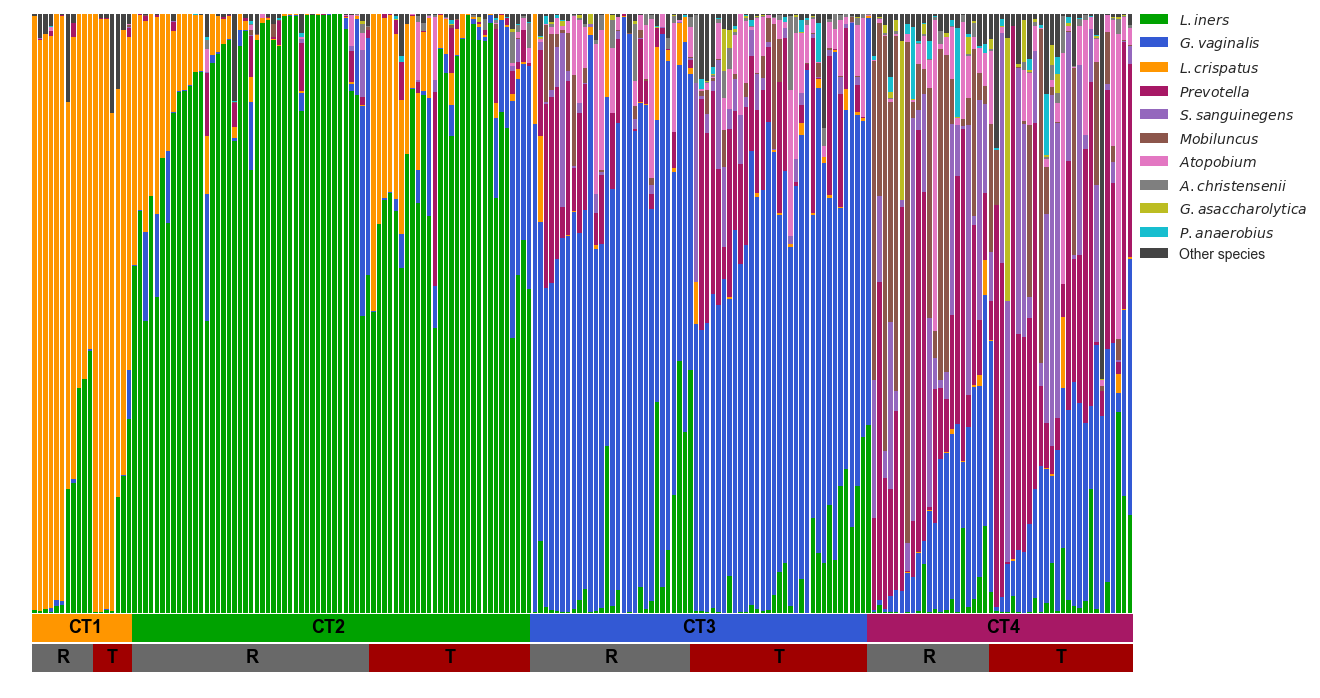

In [22]:
# order otu dataframe by transitions to prep for stacked barplot plotting
stack_orderedids, translens, states = [], [], []
for startct in ['CT1','CT2','CT3','CT4']:
    for return_str in ['_WR', '_WNR']:
        state = str(startct)+return_str
        idscurr = cttrans_dict[state]
        idscurr = list(pcoa_df.loc[idscurr,:].iloc[:,1].sort_values().index.values)
        stack_orderedids += idscurr
        translens.append(len(idscurr))
        states.append(state)

# sort and filter fractional otu table
sortedcols = fracotu.sum(axis=0).sort_values(ascending=False).index.values
fracotu = fracotu.loc[stack_orderedids,sortedcols]
fracotufilt = fracotu.iloc[:,:10]

# plot
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(3, 5, height_ratios=[20,1,1])
gs.update(wspace=0, hspace=0)
ax = fig.add_subplot(gs[0, :-1])
ax.axis('off')
ax.patch.set_facecolor('white')
colors3 = [COLORS[i] for i in [1,2,0,3]]+list(plt.cm.tab10.colors[4:])
matplotlib.rcParams.update({'font.size': 18})
ind = np.arange(fracotufilt.shape[0])
locs = [np.sum(translens[:i]) for i in range(len(translens))] + [fracotu.shape[0]]
bars = []
for i in range(fracotufilt.shape[1]+1):
    if i==0:
        b = ax.bar(ind, fracotufilt.iloc[:,i], color=colors3[i], align='edge')
    elif i==fracotufilt.shape[1]:
        b = ax.bar(ind, 1-fracotufilt.sum(axis=1), color='#444444', bottom=fracotufilt.sum(axis=1), align='edge')
    else:
        b = ax.bar(ind, fracotufilt.iloc[:,i], color=colors3[i], bottom=fracotufilt.iloc[:,:i].sum(axis=1), align='edge')
    bars.append(b)
ax.set_xlim([0,fracotufilt.shape[0]-1])
    
ax = fig.add_subplot(gs[1,:-1])
cmap = matplotlib.colors.ListedColormap(COLORS)
bounds = [0,1.9,3.9,5.9,7.9]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
ax.imshow([[e for e,t in enumerate(translens) for j in range(t)] for a in range(5)], cmap=cmap, norm=norm)
for e,i in enumerate([9,53,120,175]):
    ax.text(i-3,2.8,'CT'+str(e+1),weight='bold',color='k')
ax.axis('off')

ax = fig.add_subplot(gs[2,:-1])
cmap = matplotlib.colors.ListedColormap(COLORS2)
bounds = [-.1,.5,1.1]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
ax.imshow([[0 if (e%2==0) else 1 for e,t in enumerate(translens) for j in range(t)] for a in range(5)], cmap=cmap, norm=norm)
wr_locs = [(a+b)/2 for a,b in zip(locs,locs[1:])]
for i in range(8):
    if i%2==0:
        ax.text(wr_locs[i]-1.5,2.85,'R',weight='bold',color='k')
    else:
        ax.text(wr_locs[i]-1.5,2.85,'T',weight='bold',color='k')
ax.axis('off')

ll = [' '.join(a.split()[1:]) for a in fracotufilt.columns]
legend_labels = []
for l in ll:
    splitted = l.split()
    if len(splitted)>1:
        if splitted[1]=='no_iners':
            legend_labels.append('$\it{L. crispatus}$')
        else:
            legend_labels.append('$\it{'+splitted[0][0]+'. '+splitted[1]+'}$')
    else:
        legend_labels.append('$\it{'+l+'}$')
legend_labels.append('Other species')
plt.legend([bc[0] for bc in bars], legend_labels, prop={'size':14}, bbox_to_anchor=(1.17,24.3))
plt.tight_layout()
plt.savefig('figures/abundances.pdf', bbox_inches='tight')
plt.show()

### Significant taxa

In [17]:
# make files with non-NA ids by ct category
allct_ids = list(map_df[map_df.Willreturn_CT != 'NA']['#SampleID'])
with open("data/qiime/6diff_abundance/allcts/ids.txt", "w") as ids_file:
    for ctcurr in allct_ids:
        currline = ctcurr+'\n'
        ids_file.write(currline)

for ct in [1,2,3,4]:
    ct_ids = list(map_df[map_df.Willreturn_CT.str[0] == str(ct)]['#SampleID'])
    filepath = "data/qiime/6diff_abundance/ct"+str(ct)+"/ids.txt"
    with open(filepath, "w") as ids_file:
        for ctcurr in ct_ids:
            currline = ctcurr+'\n'
            ids_file.write(currline)

*** Create new biom otu tables by filtering the ids from the files generated above. ***

```bash
filter_samples_from_otu_table.py -i 1rarefaction5000/rarefy5000.biom -o 6diff_abundance/allcts/otu_allctfiltered.biom --sample_id_fp 6diff_abundance/allcts/ids.txt

filter_samples_from_otu_table.py -i 1rarefaction5000/rarefy5000.biom -o 6diff_abundance/ct1/otu_ct1filtered.biom --sample_id_fp 6diff_abundance/ct1/ids.txt

filter_samples_from_otu_table.py -i 1rarefaction5000/rarefy5000.biom -o 6diff_abundance/ct2/otu_ct2filtered.biom --sample_id_fp 6diff_abundance/ct2/ids.txt

filter_samples_from_otu_table.py -i 1rarefaction5000/rarefy5000.biom -o 6diff_abundance/ct3/otu_ct3filtered.biom --sample_id_fp 6diff_abundance/ct3/ids.txt

filter_samples_from_otu_table.py -i 1rarefaction5000/rarefy5000.biom -o 6diff_abundance/ct4/otu_ct4filtered.biom --sample_id_fp 6diff_abundance/ct4/ids.txt
```

*** Check filtered otu tables for differentially abundant otu's, using a non-parametric t-test to compare samples that will return and samples that won't return. ***

```bash
group_significance.py -i 6diff_abundance/allcts/otu_allctfiltered.biom -m 4map/map.txt -c Willreturn_bool -o 6diff_abundance/allcts/allct_sigs.txt -s nonparametric_t_test

group_significance.py -i 6diff_abundance/ct1/otu_ct1filtered.biom -m 4map/map.txt -c Willreturn_CT -o 6diff_abundance/ct1/ct1_sigs.txt -s nonparametric_t_test

group_significance.py -i 6diff_abundance/ct2/otu_ct2filtered.biom -m 4map/map.txt -c Willreturn_CT -o 6diff_abundance/ct2/ct2_sigs.txt -s nonparametric_t_test

group_significance.py -i 6diff_abundance/ct3/otu_ct3filtered.biom -m 4map/map.txt -c Willreturn_CT -o 6diff_abundance/ct3/ct3_sigs.txt -s nonparametric_t_test

group_significance.py -i 6diff_abundance/ct4/otu_ct4filtered.biom -m 4map/map.txt -c Willreturn_CT -o 6diff_abundance/ct4/ct4_sigs.txt -s nonparametric_t_test
```

In [23]:
def print_sigs(ctnum, alpha=.05):
    ''' prints species significantly different between samples that will return and wont return '''
    print "\n\nCT"+str(ctnum)
    df = pd.read_csv('Data/qiime/6diff_abundance/ct'+str(ctnum)+'/ct'+str(ctnum)+'_sigs.txt', sep='\t')
    df = df[df.P < alpha]
    sigs = []
    for rownum in range(df.shape[0]):
        otu = df.iloc[rownum,0]
        pval = str(round(df.iloc[rownum,2],5))
        wontreturn_mean = df.iloc[rownum,:][str(ctnum)+'_wontreturn_mean']
        willreturn_mean = df.iloc[rownum,:][str(ctnum)+'_willreturn_mean']
        if willreturn_mean < 200 and wontreturn_mean < 200:
            continue #small abundances
        sigs.append(otu)
        upwillreturn = "+" if willreturn_mean>wontreturn_mean else "-"
        printstr = otu+' ==> '+pval+" ("+upwillreturn+")"
        print printstr
    return sigs

print "Significantly different taxa with p-value and + for increased in returners, - for decreased"

s1 = print_sigs(ctnum=1)
s2 = print_sigs(ctnum=2)
s3 = print_sigs(ctnum=3)
s4 = print_sigs(ctnum=4)
all_significanttaxa = s1+s2+s3+s4
all_significanttaxa = sorted(all_significanttaxa)[::-1]

Significantly different taxa with p-value and + for increased in returners, - for decreased


CT1


CT2
Lactobacillaceae Lactobacillus iners ==> 0.01199 (+)
Bifidobacteriaceae Gardnerella vaginalis ==> 0.04396 (-)


CT3


CT4
Actinomycetaceae Mobiluncus ==> 0.001 (+)


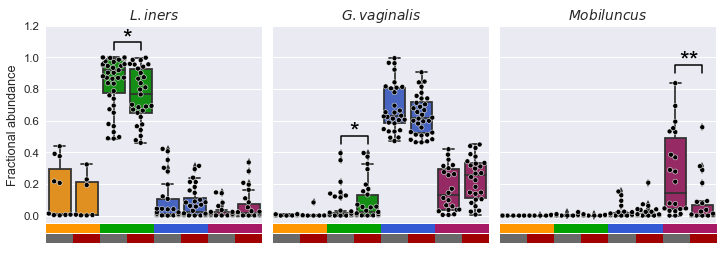

In [27]:
# construct dataframe with siginificant taxa abundances and return status
taxadf = deepcopy(fracotu[all_significanttaxa])
taxadf['Willreturn_CT'] = deepcopy(map_df).set_index('#SampleID').Willreturn_CT.loc[taxadf.index]
taxadf = taxadf.drop(taxadf[taxadf.Willreturn_CT=='NA'].index)      

# plot
sns.set(font_scale=1.15)
fig = plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(3, 3, height_ratios=[20,1,1])
gs.update(wspace=0.05, hspace=0)
for e,sigtaxa in enumerate(all_significanttaxa):
    a = fig.add_subplot(gs[0,e])
    sns.boxplot(x='Willreturn_CT', y=sigtaxa, data=taxadf, palette=np.repeat(COLORS,2), ax=a, \
                order=[str(pre)+suf for pre in range(1,5) for suf in ['_willreturn','_wontreturn']])
    sns.swarmplot(x='Willreturn_CT', y=sigtaxa, data=taxadf, color='0', linewidth=.5, edgecolor='white', ax=a, \
                  order=[str(pre)+suf for pre in range(1,5) for suf in ['_willreturn','_wontreturn']])
    a.set_xlabel('')
    a.set_xticks([])
    a.set_title(['$\it{L. iners}$', '$\it{G. vaginalis}$', '$\it{Mobiluncus}$'][e])
    a.set_ylim([-.05,1.2])
    a.set_ylabel('')
    if e==0:
        a.plot([2, 2, 3, 3], [1.05, 1.1, 1.1, 1.05], lw=1.5, c='k')
        a.text((2+3)*.5, 1.04, "*", ha='center', va='bottom', color='k', fontsize=25)
        a.set_ylabel('Fractional abundance')
    elif e==1:
        a.plot([2, 2, 3, 3], [.45, .5, .5, .45], lw=1.5, c='k')
        a.text((2+3)*.5, .45, "*", ha='center', va='bottom', color='k', fontsize=25)
        a.set_yticklabels([])
    elif e==2:
        a.plot([6, 6, 7, 7], [.9, .95, .95, .9], lw=1.5, c='k')
        a.text((6+7)*.5, 0.9, "**", ha='center', va='bottom', color='k', fontsize=25)
        a.set_yticklabels([])

for col in range(3):
    ax = fig.add_subplot(gs[1,col])
    cmap = matplotlib.colors.ListedColormap(COLORS)
    bounds = [0,1.9,2.9,3.9,4.9]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    ax.imshow([[i for i in range(1,5) for j in range(6)]], cmap=cmap, norm=norm)
#     for i in range(1,5):
#         ax.text((i-1)*4+1,0.15,'CT'+str(i),weight='bold',color='k')
    ax.axis('off')
    
    ax = fig.add_subplot(gs[2,col])
    cmap = matplotlib.colors.ListedColormap(COLORS2)
    bounds = [-.1,.5,1.1]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    ax.imshow([[j for i in range(1,5) for j in range(2) for k in range(3)]], cmap=cmap, norm=norm)
#     for i in range(8):
#         if i%2==0:
#             ax.text(2*i+.2,0.15,'WR',weight='bold',color='k')
#         else:
#             ax.text(2*i,0.15,'WNR',weight='bold',color='k')
    ax.axis('off')

plt.savefig('figures/significant_taxa.pdf', bbox_inches='tight')
plt.show()

### Plot pcoa-space animations

In [37]:
# animation of a moving point in pcoa space
frames_per_segment = 20
colors = plt.cm.tab10.colors
#plt.rcParams['animation.ffmpeg_path'] = u'/Users/KwonMacBookPro/anaconda/bin/ffmpeg'
#c=colors[segment%len(colors)]; colors[0]

def animate(i, ax):
    segment = i // frames_per_segment
    x1, y1 = pcoa_df.loc[sample_ids[segment],:][0], pcoa_df.loc[sample_ids[segment],:][1]
    x2, y2 = pcoa_df.loc[sample_ids[segment+1],:][0], pcoa_df.loc[sample_ids[segment+1],:][1]
    x_curr = x1 + ((i%frames_per_segment)/frames_per_segment)*(x2-x1)
    y_curr = y1 + ((i%frames_per_segment)/frames_per_segment)*(y2-y1)
    pt_new = ax.scatter(x_curr, y_curr, s=80, c='k', edgecolors='w')
    return [pt_new]

def movingdot_animation(sample_ids, file_suffix=''):
    ''' makes moving dot in pcoa space given list of sample ids '''
    fig = plt.figure()
    ax = plt.axes(xlim=(-.7,.8), ylim=(-.95,.4))
    prettify_ax(ax)
    col1, col2 = pcoa_df.columns.values[0], pcoa_df.columns.values[1]
    xlabel = 'PC1 ' + str(int(float(col1)*100))+'%'
    ylabel = 'PC2 ' + str(int(float(col2)*100))+'%'
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    for ell in generate_ellipses():
        ax.add_artist(ell)
    for sampleid in pcoa_df.index.values: #scatter
        ct = ct_df.loc[sampleid, 'CT']
        ax.scatter(pcoa_df.loc[sampleid, col1], pcoa_df.loc[sampleid, col2], c=COLORS[ct-1], \
                   edgecolors='w', s=80, alpha=0.5)
    pt = ax.scatter(pcoa_df.loc[sample_ids[0],:][0], pcoa_df.loc[sample_ids[0],:][1],\
                    c='k', s=80, edgecolors='w')
    num_frames = (len(sample_ids)-1)*frames_per_segment-1
    anim = animation.FuncAnimation(fig=fig, \
                                   func=animate, \
                                   frames=num_frames, \
                                   interval=100, \
                                   fargs=(ax,))
    anim_title = 'figures/animations/'+file_suffix+'.mp4'
    anim.save(anim_title)
    
def markov_step(old_id, p_move=1):
    ''' given an id, step in the markov network and return a new id '''
    split = old_id.split('.')
    old_k = split[0]+'.'+split[1]
    old_i = ids[old_k].index(int(split[2]))
    if np.random.random()<p_move:
        new_k = old_k
        new_i = old_i if old_i==(len(ids[new_k])-1) else old_i+1
        new_id = new_k+'.'+str(ids[new_k][new_i])
        x, y = (pcoa_df.loc[new_id][0], pcoa_df.loc[new_id][1])
        loading1, loading2 = (float(pcoa_df.columns.values[0]), float(pcoa_df.columns.values[1]))
        poss_pts = pcoa_df.iloc[:,:2]
        poss_pts['distance'] = (loading1*(poss_pts.iloc[:,0]-x))**2 + (loading2*(poss_pts.iloc[:,1]-y))**2
        expodecay_probs = np.exp(-poss_pts.distance)/np.sum(np.exp(-poss_pts.distance)) #exponential distance decay
        rand_row = np.random.choice(poss_pts.shape[0], p=expodecay_probs)
        rand_id = poss_pts.iloc[rand_row,:].name
        return rand_id
    else:
        return old_id

In [ ]:
# animation : demo of sample traveling through pcoa space
sample_prefix = '0424.282'
sample_ids = [sample_prefix+'.'+str(sample_suffix) for sample_suffix in ids[sample_prefix]]
movingdot_animation(sample_ids=sample_ids, file_suffix='sample_demo')

In [70]:
# animation : taxa-level simulations using markov probabilities
for k in range(5):
    num_states = 15
    start_id = '0055.051.1'
    sample_ids = [start_id]
    for j in range(num_states):
        prev_id = sample_ids[-1]
        next_id = markov_step(prev_id)
        sample_ids.append(next_id)
    fname = 'markov_simulation_test'+str(k)
    movingdot_animation(sample_ids=sample_ids, file_suffix=fname)

In [46]:
# animation : multiple taxa-level simulations using markov probabilities
frames_per_segment = 20
num_states = 15
num_samples = 3
colors = plt.cm.tab10.colors
start_id = '0055.051.1'
lines_data = [[] for a in range(num_samples)]
lines = []

def multiple_animate(i, ax):
    global num_samples
    segment = i // frames_per_segment
    pt_new_list = []
    for sample_num, sample_ids in enumerate(sample_ids_list):
        x1, y1 = pcoa_df.loc[sample_ids[segment],:][0] + .01*sample_num*(num_samples<=5), \
                 pcoa_df.loc[sample_ids[segment],:][1] + .01*sample_num*(num_samples<=5)
        x2, y2 = pcoa_df.loc[sample_ids[segment+1],:][0] + .01*sample_num*(num_samples<=5), \
                 pcoa_df.loc[sample_ids[segment+1],:][1] + .01*sample_num*(num_samples<=5)
        x_curr = x1 + ((i%frames_per_segment)/frames_per_segment)*(x2-x1)
        y_curr = y1 + ((i%frames_per_segment)/frames_per_segment)*(y2-y1)
        lines_data[sample_num] = lines_data[sample_num] + [(x_curr, y_curr)]
        currline_x, currline_y = [l[0] for l in lines_data[sample_num]], [l[1] for l in lines_data[sample_num]]
        lines[sample_num].set_data(currline_x, currline_y)
    if i!=0 and i%50==0:
        num_samples = (len(sample_ids_list[0])-1)*frames_per_segment
        print i, "/", num_samples, "frames done." 
    return lines

def multiple_movingdot_animations(sample_ids_list, file_name=''):
    ''' makes moving dot in pcoa space given list of sample ids '''
    fig = plt.figure()
    ax = plt.axes(xlim=(-.7,.8), ylim=(-.95,.4))
    prettify_ax(ax)
    col1, col2 = pcoa_df.columns.values[0], pcoa_df.columns.values[1]
    xlabel = 'PC1 ' + str(int(float(col1)*100))+'%'
    ylabel = 'PC2 ' + str(int(float(col2)*100))+'%'
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    for sampleid in pcoa_df.index.values:
        ct = ct_df.loc[sampleid, 'CT']
        ax.scatter(pcoa_df.loc[sampleid, col1], pcoa_df.loc[sampleid, col2], c=COLORS[ct-1], \
                   edgecolors='w', s=80, alpha=0.3)
    for sample_num, sample_ids in enumerate(sample_ids_list):
        x_curr, y_curr = pcoa_df.loc[sample_ids[0],:][0] + .01*sample_num*(num_samples<=5), \
                         pcoa_df.loc[sample_ids[0],:][1] + .01*sample_num*(num_samples<=5)
        lines_data[sample_num] = lines_data[sample_num] + [(x_curr, y_curr)]
        line, = ax.plot([x_curr], [y_curr], c=colors[sample_num%len(colors)])
        lines.append(line)
    num_frames = (len(sample_ids_list[0])-1)*frames_per_segment-1
    anim = animation.FuncAnimation(fig=fig, \
                                   func=multiple_animate, \
                                   frames=num_frames, \
                                   interval=100, \
                                   fargs=(ax,))
    anim_title = 'figures/animations/'+file_name+'.mp4'
    anim.save(anim_title)
    
# 10 stochastic samples with 15 transitions each
sample_ids_list = []
for sample in range(num_samples):
    sample_ids = [start_id]
    for j in range(num_states):
        prev_id = sample_ids[-1]
        next_id = markov_step(prev_id)
        sample_ids.append(next_id)
    sample_ids_list.append(sample_ids)
print "Samples drawn."
fname = 'multiple_markov_simulation_test'
multiple_movingdot_animations(sample_ids_list, file_name=fname)
print "Animation complete and successfully saved to ./figures/animations/"

Samples drawn.
50 / 300 frames done.
100 / 300 frames done.
150 / 300 frames done.
200 / 300 frames done.
250 / 300 frames done.
Animation complete and successfully saved to ./figures/animations/


### Heatmap Animation

In [41]:
# sorted otu names and abbrevs to replicate figure 1 in Melis Anahtar, et al., Immunity 2015
sorted_cols = ['Lactobacillaceae Lactobacillus no_iners',\
               'Lactobacillaceae Lactobacillus iners',\
               'Bifidobacteriaceae Gardnerella vaginalis',\
               'Prevotellaceae Prevotella',\
               'Lachnospiraceae',\
               'Leptotrichiaceae Sneathia sanguinegens',\
               'Veillonellaceae Megasphaera micronuciformis',\
               'Actinomycetaceae Mobiluncus',\
               'Coriobacteriaceae Atopobium']
sorted_colnames = ['L. crispatus',\
                   'L. iners',\
                   'G. vaginalis',\
                   'Prevotella',\
                   'Lachnospiraceae',\
                   'Sneathia',\
                   'Megasphaera',\
                   'Mobiluncus',\
                   'Atopobium']

In [42]:
# define helper functions
def assign_ct(sample_id):
    ''' assigns a ct given a sample id '''
    global ct_df
    return ct_df.loc[sample_id, 'CT']   

def heatmap_sortids(sampleid_list, otu_table, pc=2):
    ''' given a list of sample ids and an input otu table, sorts ids by ct and pc '''
    assigned_cts = np.array([assign_ct(sample_id) for sample_id in sampleid_list])
    sorted_fullidlist = []
    for ctcurr in [1,2,3,4]:
        idscurr = np.array(sampleid_list)[np.where(assigned_cts==ctcurr)[0]]
        sorted_idscurr = pcoa_df.loc[idscurr,:].iloc[:,pc-1].sort_values().index.values
        sorted_fullidlist = sorted_fullidlist + list(sorted_idscurr)
    return sorted_fullidlist

def generate_heatmapstring(frac_abundances, bounds=[0,.01,.1,.5,1]):
    ''' return heatmap categories string based on fractional abundances for sample '''
    categories = []
    for frac_abundance in frac_abundances:
        if frac_abundance < bounds[1]:
            categories.append(1)
        elif frac_abundance < bounds[2]:
            categories.append(2)
        elif frac_abundance < bounds[3]:
            categories.append(3)
        else:
            categories.append(4)
    return categories

def animate_heatmap(n_steps=20, starting_id='0422.293.1'):
    ''' animates a heatmap given a starting id and number of steps to simulate '''
    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.imshow(np.random.random((50,50)))
    plt.show(block=False)
    for step in range(n_steps):
        time.sleep(1)
        im.set_array(np.random.random((50,50)))
        fig.canvas.draw()

In [ ]:
# generate dictionary with heatmap_strings
heatmapstring_dict = {}
for k in ids.keys():
    categories_buffer = []
    for i in ids[k]:
        idcurr = k+'.'+str(i)
        fracabund_curr = fracotu.loc[idcurr, sorted_cols]
        categories_curr = generate_heatmapstring(fracabund_curr)
        categories_buffer.append(categories_curr)
    heatmapstring_dict[k] = categories_buffer

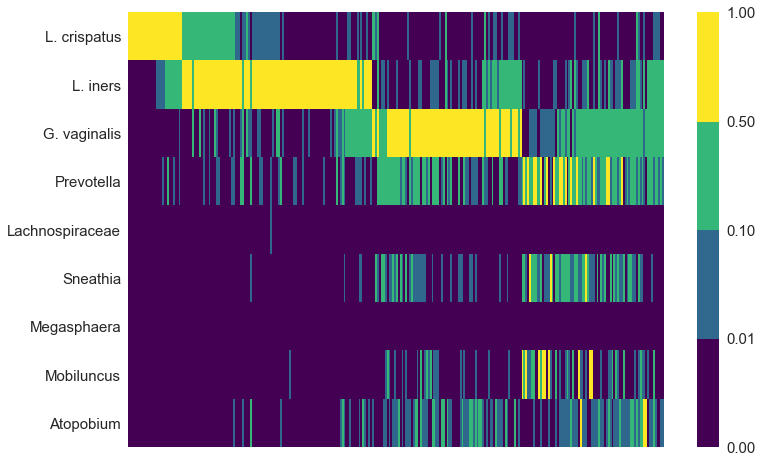

In [61]:
# replicate static figure 1 from Melis Anahtar, et al., Immunity 2015
sorted_idx = heatmap_sortids(fracotu.index.values, fracotu)
hm_fracotu = fracotu.loc[sorted_idx, sorted_cols].T

f,a = simple_ax(figsize=(12,8)) 
bounds = np.array([0, .01, .1, .5, 1])
norm = pltcolors.BoundaryNorm(boundaries=bounds, ncolors=4)
plt.imshow(hm_fracotu, cmap=plt.cm.get_cmap('viridis', 4), aspect='auto', norm=norm)
plt.colorbar()
a.set_xticks([])
a.set_yticks(range(len(sorted_colnames)))
a.set_yticklabels(sorted_colnames, fontsize=15)
a.grid(False)
plt.savefig('figures/taxatable_stable.pdf', bbox_inches='tight')
plt.show()

In [68]:
fig, ax = simple_ax(figsize=(12,8))
matplotlib.rcParams['animation.html'] = 'html5'
ids_list = ['0055.051.1' for j in range(pcoa_df.shape[0])]
sorted_idx = heatmap_sortids(ids_list, fracotu)
hm_curr = fracotu.loc[sorted_idx, sorted_cols].T
im = plt.imshow(hm_curr, cmap=plt.cm.get_cmap('viridis', 4), aspect='auto', norm=norm)
plt.colorbar()
ax.set_xticks([])
ax.set_yticks(range(len(sorted_colnames)))
ax.set_yticklabels(sorted_colnames, fontsize=13)
ax.grid(False)

def init():
    sorted_idx = heatmap_sortids(['0055.051.1' for j in range(pcoa_df.shape[0])], fracotu)
    hm_curr = fracotu.loc[sorted_idx, sorted_cols].T
    im = plt.imshow(hm_curr, cmap=plt.cm.get_cmap('viridis', 4), aspect='auto', norm=norm)
    return [im]

def animate(i):
    global ids_list
    if i != 0:
        ids_list = [markov_step(old_id, p_move=0.1) for old_id in ids_list]
    sorted_idx = heatmap_sortids(ids_list, fracotu)
    hm_curr = fracotu.loc[sorted_idx, sorted_cols].T
    im = plt.imshow(hm_curr, cmap=plt.cm.get_cmap('viridis', 4), aspect='auto', norm=norm)
    #plt.savefig('figures/animations/statics/'+str(i)+'.pdf',bbox_inches='tight')
    return [im]

anim = animation.FuncAnimation(fig=fig, func=animate, init_func=init, \
                               frames=50, interval=500, blit=True)
anim.save('figures/animations/taxatable_test.mp4')